In [ ]:
!pip install ipywidgets
!pip install tqdm
!pip install ipywidgets --upgrade
!pip install geopandas
!pip install geopy
!pip install snscrape
!pip install folium
!pip install seaborn

In [9]:
# import libraries
import pandas as pd 

import numpy as np 

import snscrape.modules.twitter as sntwitter 

import datetime 

from tqdm.notebook import tqdm_notebook 

import seaborn as sns 

import matplotlib.pyplot as plt 

sns.set_theme(style="whitegrid") 

# Get input from user

In [4]:
# Get input from user

text = input('Enter query text to be matched (or leave it blank by pressing enter)') 

username = input('Enter specific username(s) from a twitter account without @ (or leave it blank by pressing enter): ') 

since = input('Enter startdate in this format yyyy-mm-dd (or leave it blank by pressing enter): ') 

until = input('Enter enddate in this format yyyy-mm-dd (or leave it blank by pressing enter): ') 

count = int(input('Enter max number of tweets or enter -1 to retrieve all possible tweets: ')) 

retweet = input('Exclude Retweets? (y/n): ') 

replies = input('Exclude Replies? (y/n): ') 


In [10]:
# Function to search tweets

import datetime

def search(text, username, since, until, retweet, replies):
    global filename
    
    q = text
    
    if username != '':
        q += f" from:{username}"
        
    if until == '':
        until = datetime.datetime.strftime(datetime.date.today(), '%Y-%m-%d')
    
    q += f" until:{until}"
    
    if since == '':
        since = datetime.datetime.strftime(datetime.datetime.strptime(until, '%Y-%m-%d') - datetime.timedelta(days=7), '%Y-%m-%d')
    
    q += f" since:{since}"
    
    if retweet == 'y':
        q += f" exclude:retweets"
    
    if replies == 'y':
        q += f" exclude:replies"
    
    if username != '' and text != '':
        filename = f"{since}_{until}_{username}_{text}.csv"
    elif username != "":
        filename = f"{since}_{until}_{username}.csv"
    else:
        filename = f"{since}_{until}_{text}.csv"
    
    print(filename)
    
    return q



In [ ]:
#  3. The script should also print the following information:

q = search(text,username,since,until,retweet,replies)

# Creating list to append tweet data
tweets_list1 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
if count == -1:
    for i,tweet in enumerate(tqdm_notebook(sntwitter.TwitterSearchScraper(q).get_items())):
        tweets_list1.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username,tweet.lang,
                             tweet.hashtags,tweet.replyCount,tweet.retweetCount, tweet.likeCount,tweet.quoteCount,tweet.sourceLabel,tweet.media])
else:
    with tqdm_notebook(total=count) as pbar:
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(q).get_items()): #declare a username
            if i>=count: #number of tweets you want to scrape
                break
            tweets_list1.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username,tweet.lang,tweet.hashtags,tweet.coordinates,tweet.replyCount,
                                  tweet.retweetCount,tweet.likeCount,tweet.quoteCount,tweet.sourceLabel, tweet.media])
            pbar.update(1)

# Creating a dataframe from the tweets list above
tweets_df1 = pd.DataFrame(tweets_list1, columns=['DateTime', 'TweetId', 'Text', 'Username','Language',
                                                 'Hashtags','Cords','ReplyCount','RetweetCount','LikeCount','QuoteCount','Source','Media'])


In [7]:
#tweets_df1.sort_values(by='DateTime',ascending=False) 
tweets_df1.columns

Index(['DateTime', 'TweetId', 'Text', 'Username', 'Language', 'Hashtags',
       'Cords', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount',
       'Source', 'Media'],
      dtype='object')

In [8]:
tweets_df1.head(1)

,DateTime,TweetId,Text,Username,Language,Hashtags,Cords,ReplyCount,RetweetCount,LikeCount,QuoteCount,Source,Media
0,2023-03-31 23:59:34+00:00,1641953414924886024,People go use lyrics finish Yakubu ooo with th...,Michaelblaque07,en,[MrYakubuChallenge],None,0,0,0,0,Twitter for iPhone,None


In [120]:
# Drop rows with no coordinates or NaN, None
tweets_df1 = tweets_df1.dropna(subset=['Cords'])

In [10]:
#create a new dataframe called tweets_df2 for preprocessing for visualization later
tweets_df2 = tweets_df1

In [11]:
#tweets_df2.head(1)
tweets_df = tweets_df2.head

,DateTime,TweetId,Text,Username,Language,Hashtags,Cords,ReplyCount,RetweetCount,LikeCount,QuoteCount,Source,Media
7,2023-03-02 23:57:41+00:00,1631443692316655616,Tinubu's declaration turns Nigerians into mour...,dnservicesnig,en,None,"Coordinates(longitude=7.1415877, latitude=4.80...",0,0,0,0,Twitter for Android,None


In [ ]:
#tweets_df1.head(3)
!pip install pandas-profiling
!pip install plotly
!pip install nbformat>=4.2.0
!pip install networkx>=2.4



In [121]:
# Plot of heatmap showing locations where the word INEC is being mention around the word using Plotly Express
import plotly.express as px

tweets_df1['Lat'] = tweets_df1['Cords'].apply(lambda x: x.latitude if x else None)
tweets_df1['Lon'] = tweets_df1['Cords'].apply(lambda x: x.longitude if x else None)

tweets_df1 = tweets_df1.dropna(subset=['Lat', 'Lon'], how='all')

fig = px.density_mapbox(tweets_df1, lat='Lat', lon='Lon', hover_name='Text',
                      width=1000, height=600, mapbox_style='stamen-terrain', title='Tweet Locations')

# set the map style to OpenStreetMap
#fig.update_layout(mapbox_style='stamen-terrain')
# show the plot
fig.show()

In [ ]:
# Plot of heatmap showing locations where the word INEC is being mention around the word using Plotly Express
import pandas as pd
from geopy.geocoders import Nominatim
import plotly.express as px

# initialize geolocator
geolocator = Nominatim(user_agent='my-twitter-app')

# define a function to get country from latitude and longitude
def get_country(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location is None:
        return None
    else:
        return location.raw['address']['country']

# apply the get_country function to each row of the tweet data
tweets_df1['Country'] = tweets_df1.apply(lambda row: get_country(row['Lat'], row['Lon']), axis=1)

# group the data by country and count the number of tweets
tweet_counts = tweets_df1.groupby('Country').size().reset_index(name='count')

# create a choropleth map of tweet counts by country
fig_map = px.choropleth(tweet_counts, locations='Country', locationmode='country names', color='count',
                        color_continuous_scale='YlOrRd', range_color=(0, 200),
                        title='Tweet Counts by Country')
fig_map.show()

In [ ]:
#tweets_df3 =   tweets_df2
#tweets_df3.head(1)

## Data Preprocessing

In [9]:
tweets_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   DateTime      50 non-null     datetime64[ns, UTC]
 1   TweetId       50 non-null     int64              
 2   Text          50 non-null     object             
 3   Username      50 non-null     object             
 4   Language      50 non-null     object             
 5   Hashtags      16 non-null     object             
 6   Cords         1 non-null      object             
 7   ReplyCount    50 non-null     int64              
 8   RetweetCount  50 non-null     int64              
 9   LikeCount     50 non-null     int64              
 10  QuoteCount    50 non-null     int64              
 11  Source        50 non-null     object             
 12  Media         23 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(5), object(7)
memory usage: 5.2+ K

In [10]:
# Time series of tweets
tweets_df1['Hour'] = tweets_df1['DateTime'].dt.hour

tweets_df1['Year'] = tweets_df1['DateTime'].dt.year

tweets_df1['Month'] = tweets_df1['DateTime'].dt.month

tweets_df1['MonthName'] = tweets_df1['DateTime'].dt.month_name()

tweets_df1['MonthDay'] = tweets_df1['DateTime'].dt.day

tweets_df1['DayName'] = tweets_df1['DateTime'].dt.day_name()

tweets_df1['Week'] = tweets_df1['DateTime'].dt.isocalendar().week

In [11]:
tweets_df1.head(1)

,DateTime,TweetId,Text,Username,Language,Hashtags,Cords,ReplyCount,RetweetCount,LikeCount,QuoteCount,Source,Media,Hour,Year,Month,MonthName,MonthDay,DayName,Week
0,2023-03-31 23:59:34+00:00,1641953414924886024,People go use lyrics finish Yakubu ooo with th...,Michaelblaque07,en,[MrYakubuChallenge],None,0,0,0,0,Twitter for iPhone,None,23,2023,3,March,31,Friday,13


In [12]:
# The Datetime column contains both date and time, therefore it is better to split data and time in separate columns.
tweets_df1['Date'] = [d.date() for d in tweets_df1['DateTime']]

tweets_df1['Time'] = [d.time() for d in tweets_df1['DateTime']]

In [13]:
tweets_df1.head(1)

,DateTime,TweetId,Text,Username,Language,Hashtags,Cords,ReplyCount,RetweetCount,LikeCount,...,Media,Hour,Year,Month,MonthName,MonthDay,DayName,Week,Date,Time
0,2023-03-31 23:59:34+00:00,1641953414924886024,People go use lyrics finish Yakubu ooo with th...,Michaelblaque07,en,[MrYakubuChallenge],None,0,0,0,...,None,23,2023,3,March,31,Friday,13,2023-03-31,23:59:34


In [14]:
# After splitting we will drop the DateTime column.
tweets_df1.drop('DateTime',axis=1,inplace=True)

tweets_df1.head(1)

,TweetId,Text,Username,Language,Hashtags,Cords,ReplyCount,RetweetCount,LikeCount,QuoteCount,...,Media,Hour,Year,Month,MonthName,MonthDay,DayName,Week,Date,Time
0,1641953414924886024,People go use lyrics finish Yakubu ooo with th...,Michaelblaque07,en,[MrYakubuChallenge],None,0,0,0,0,...,None,23,2023,3,March,31,Friday,13,2023-03-31,23:59:34


In [ ]:
# After splitting we will drop the DateTime column.
#tweets_df1.drop('Hashtags',axis=1,inplace=True)
#tweets_df1.drop('Media',axis=1,inplace=True)

tweets_df1.head(1)

In [34]:
#Finally our data is prepared, we will now save the dataframe as csv using df.to_csv() function which takes filename as an input parameter.
#tweets_df1.to_csv(f"{filename}",index=False)
import os
# Saving the data to a csv file for further analysis (tweets_df2)
tweets_df1.to_csv(f"cvs2{filename}",index=False)

In [12]:
tweets = pd.read_csv("2023-01-01_2023-03-03_INEC.csv")

tweets.head(1)

,TweetId,Text,Username,Language,Cords,ReplyCount,RetweetCount,LikeCount,QuoteCount,Source,...,Lon,Hour,Year,Month,MonthName,MonthDay,DayName,Week,Date,Time
0,1631443692316655616,Tinubu's declaration turns Nigerians into mour...,dnservicesnig,en,"Coordinates(longitude=7.1415877, latitude=4.80...",0,0,0,0,Twitter for Android,...,7.141588,23,2023,3,March,2,Thursday,9,2023-03-02,23:57:41


In [126]:
tweets.columns

Index(['TweetId', 'Text', 'Username', 'Language', 'Cords', 'ReplyCount',
       'RetweetCount', 'LikeCount', 'QuoteCount', 'Source', 'Lat', 'Lon',
       'Hour', 'Year', 'Month', 'MonthName', 'MonthDay', 'DayName', 'Week',
       'Date', 'Time'],
      dtype='object')

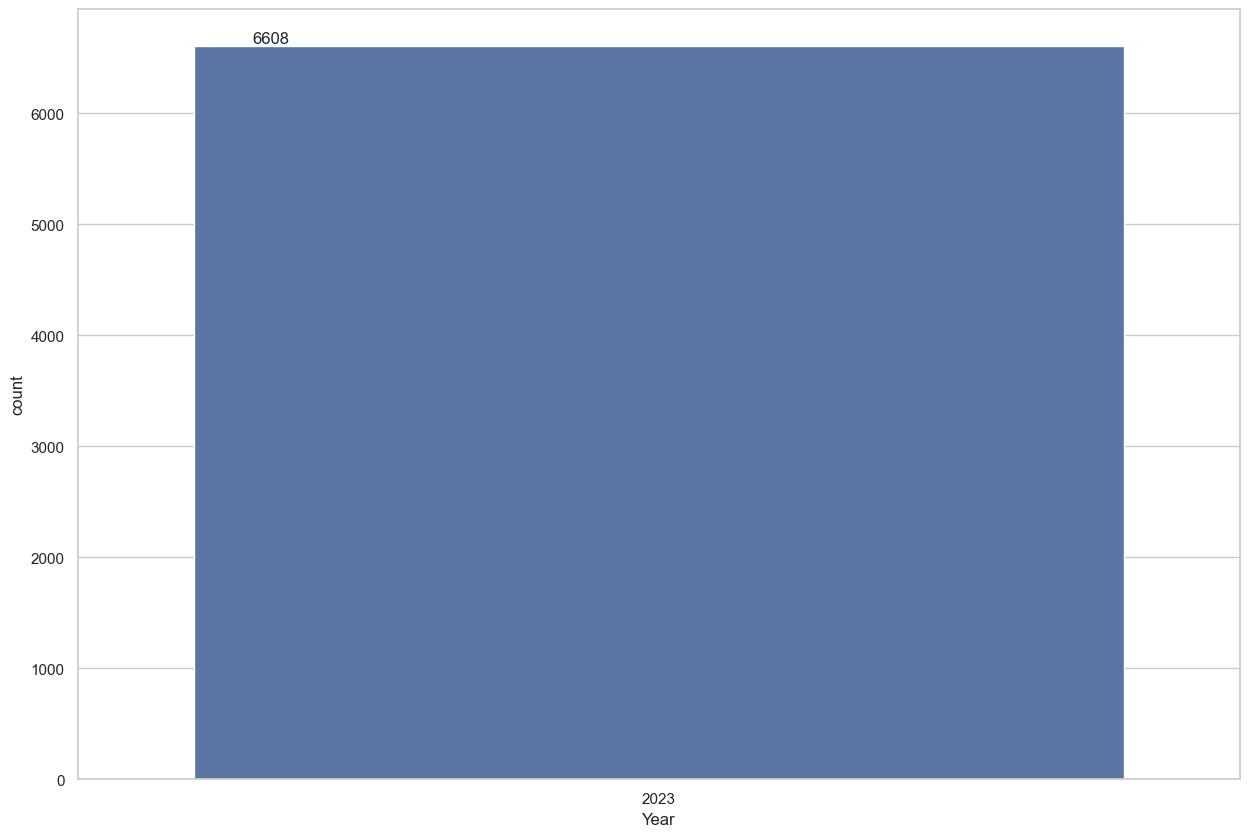

In [16]:
#Count by Year The countplot function of seaborn allows us to plot count of tweets by year. 

f, ax = plt.subplots(figsize=(15, 10)) 

sns.countplot(x= tweets['Year']) 

for p in ax.patches: 
    ax.annotate(int(p.get_height()), (p.get_x()+0.05, p.get_height()+20), fontsize = 12) 

Text(0.5, 1.0, 'Number of Tweets by Month')

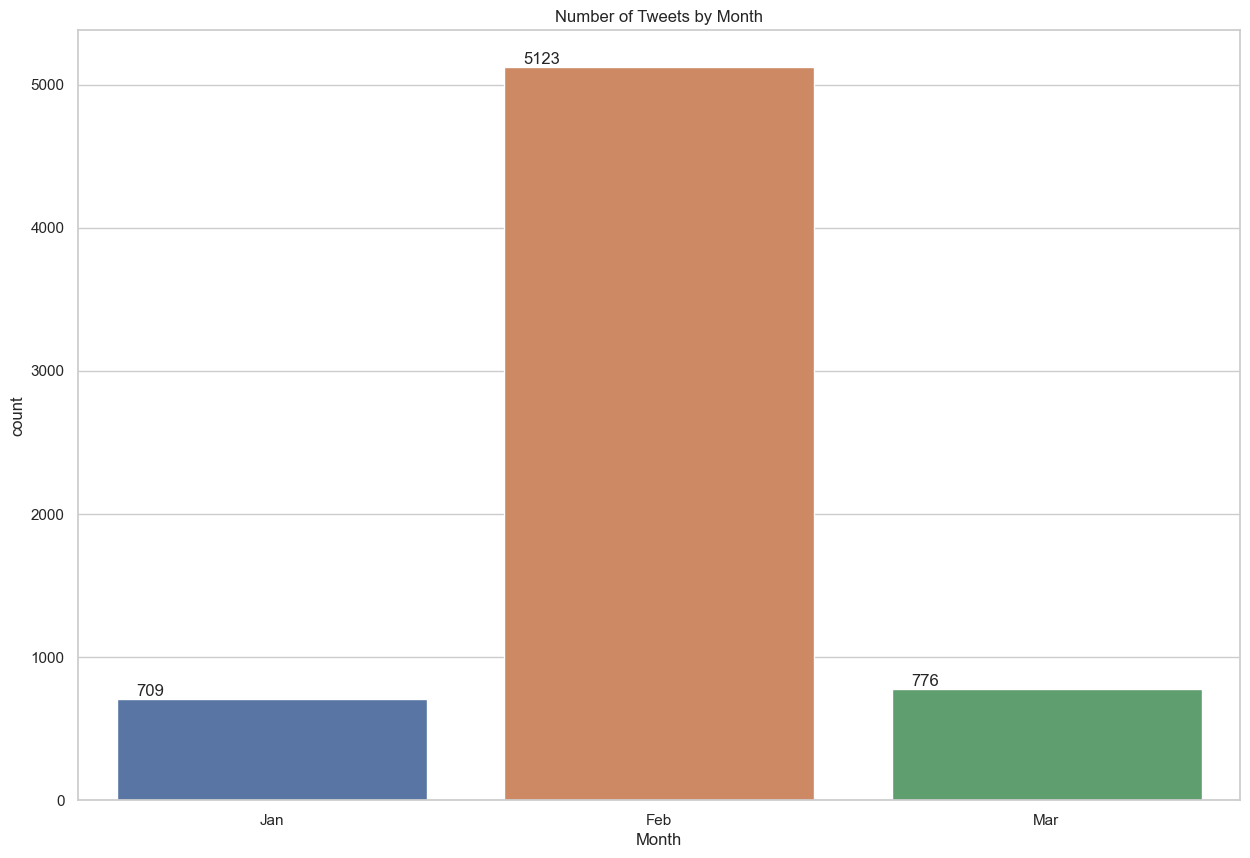

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary to map month numbers to their names
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar'}

# Replace the numerical month values with their names
tweets['Month'] = tweets['Month'].map(month_names)

# Define the order of the months
month_order = ['Jan', 'Feb', 'Mar']

# Create the countplot with the renamed x-axis labels and ordered months
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x=tweets['Month'], order=month_order)

# Annotate the non-NaN values
for p in ax.patches:
    if not np.isnan(p.get_height()):
        ax.annotate(int(p.get_height()), (p.get_x()+0.05, p.get_height()+20), fontsize=12)

# Add a title to the countplot
ax.set_title('Number of Tweets by Month')

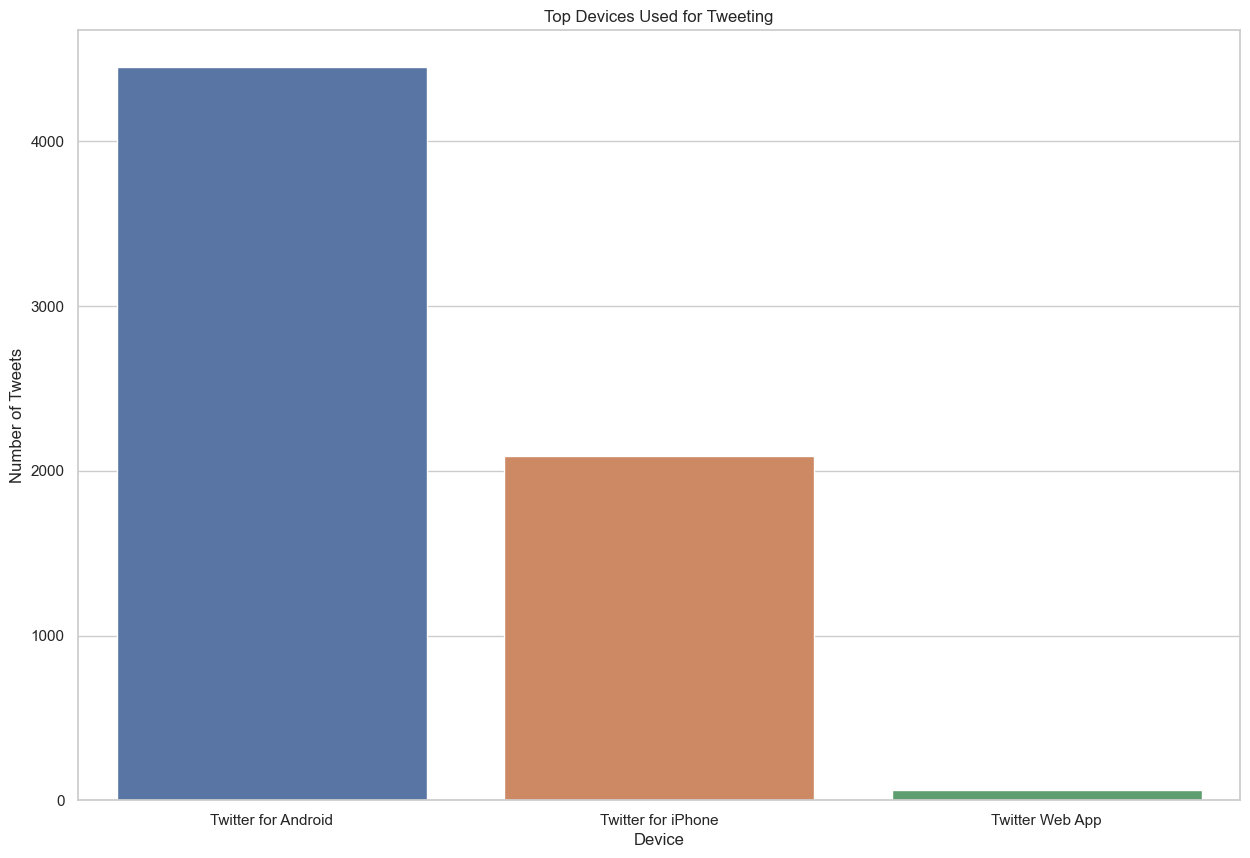

In [5]:
# Top devices used for tweeting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Get the value counts for the 'Source' column
top_devices = tweets['Source'].value_counts().head(3)

# Create a bar plot of the top devices
plt.figure(figsize=(15, 10))
sns.barplot(x=top_devices.index, y=top_devices.values)
plt.title('Top Devices Used for Tweeting')
plt.xlabel('Device')
plt.ylabel('Number of Tweets')
plt.show()

In [25]:
top_devices = tweets['Source'].value_counts().head(3)
top_devices

Twitter for Android    4452
Twitter for iPhone     2087
Twitter Web App          63
Name: Source, dtype: int64

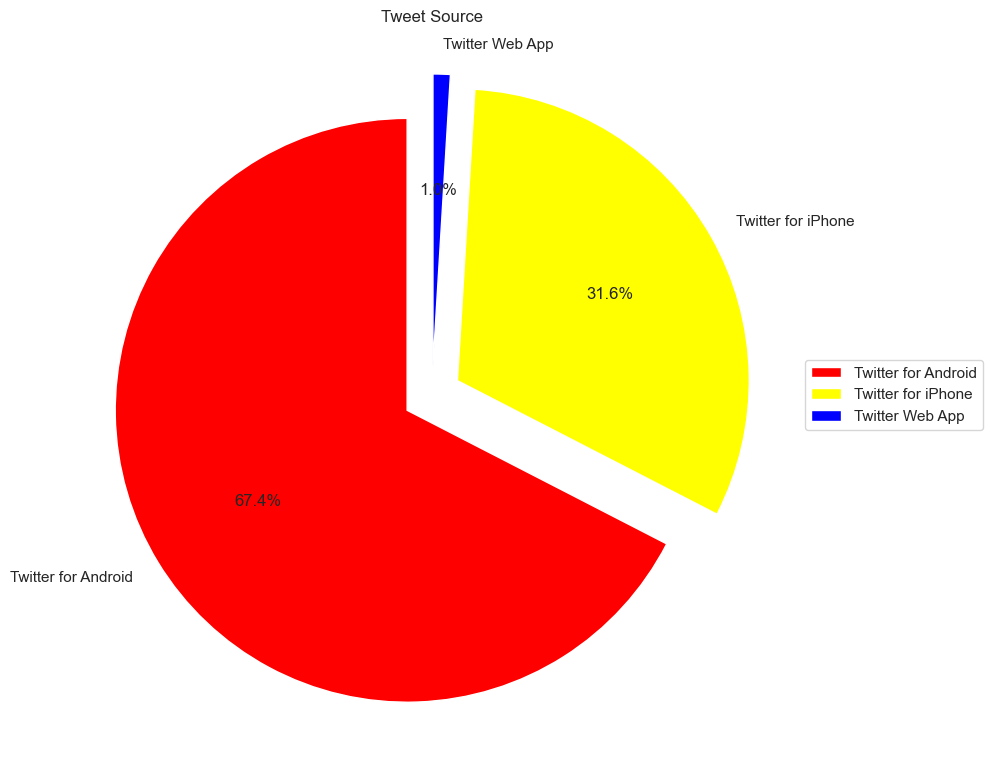

In [23]:
# Top_devices

import matplotlib.pyplot as plt

# Get the value counts for the 'Source' column
top_devices = tweets['Source'].value_counts().head(3)

# Define custom colors for the chart
colors = ['Red', 'Yellow', 'Blue', '#ffd9b3', '#ff9999', '#d9b3ff', '#ffb3ff', '#ffe6cc', '#b3ffff', '#e6f2ff']

# Define which slices to explode (i.e. pull out from the pie)
explode = [0.1] * len(top_devices)

# Create a pie chart of the top devices
plt.figure(figsize=(10, 10))
plt.pie(top_devices.values, labels=top_devices.index, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)

# Add a legend
plt.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))

# Add a title and adjust the layout
plt.title('Tweet Source')
plt.tight_layout()

# Show the plot
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


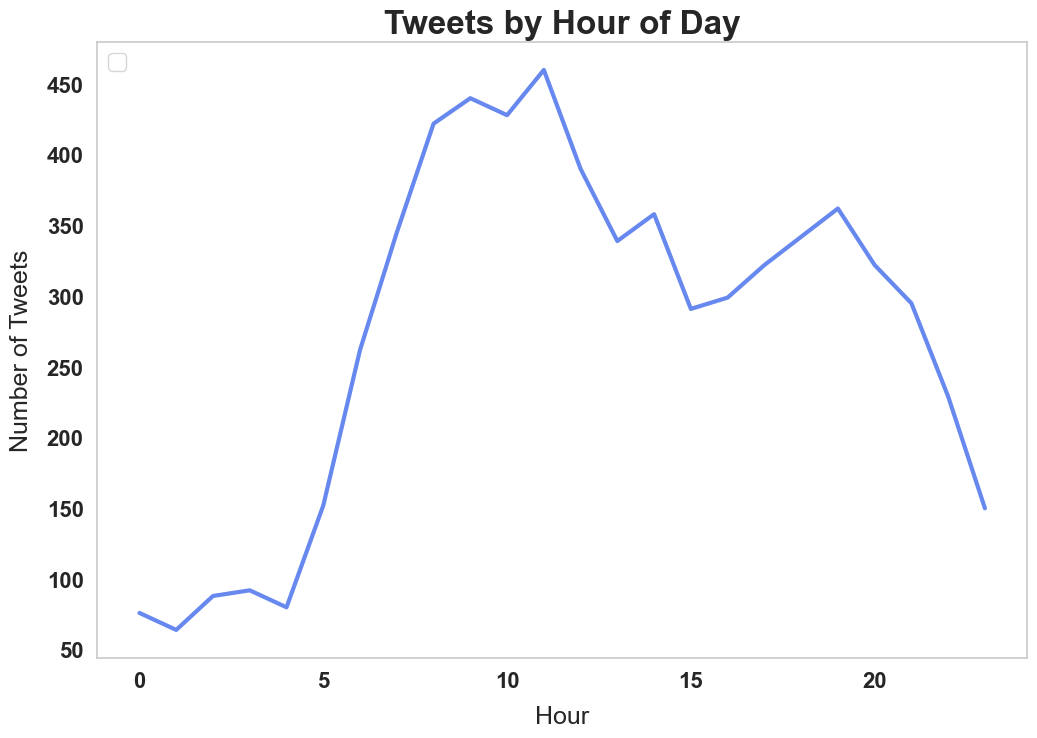

In [147]:
""" # Tweets by hour

f, ax = plt.subplots(figsize=(15, 10)) 

sns.countplot(x= tweets['Hour']) 

for p in ax.patches: 
    ax.annotate(int(p.get_height()), (p.get_x()+0.05, p.get_height()+20), fontsize = 12) 
plt.title('Tweets by Hour of Day', fontsize=16) """


import matplotlib.pyplot as plt
import seaborn as sns

# set the plot size and style
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette("coolwarm")

# create a line plot of tweets by hour
sns.lineplot(x="Hour", y="count", data=tweets.groupby('Hour').size().reset_index(name='count'), linewidth=3)

# set the title and axis labels
plt.title('Tweets by Hour of Day', fontsize=24, fontweight='bold')
plt.xlabel('Hour', fontsize=18, labelpad=10)
plt.ylabel('Number of Tweets', fontsize=18, labelpad=10)

# set the tick label font size and padding
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

# set the legend font size and position
plt.legend(fontsize=16, loc='upper left')

# add a background grid
plt.grid(color='white', linestyle='--', linewidth=0.5)

# display the plot
plt.show()




c:\ProgramData\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:ylabel='Text'>

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


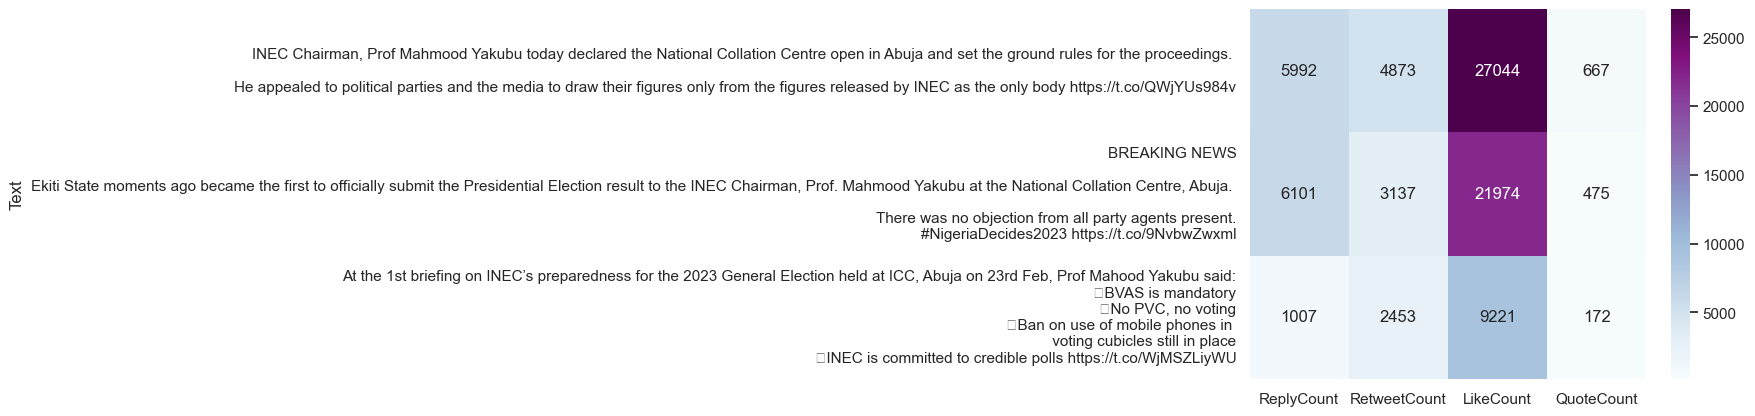

In [7]:
import pandas as pd
import seaborn as sns



# create a new column for total engagement count
tweets['EngagementCount'] = tweets['ReplyCount'] + tweets['RetweetCount'] + tweets['LikeCount'] + tweets['QuoteCount']

# select the top 10 tweets based on engagement count
top_3_tweets = tweets.nlargest(3, 'EngagementCount')

# select the columns of interest
columns = ['Text', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount']

# create a new DataFrame with only the selected columns and top 10 tweets
top_10_engagement = top_3_tweets[columns]

# use Seaborn to create a heatmap of the engagement metrics
heatmap = sns.heatmap(top_10_engagement.set_index('Text'), cmap='BuPu', annot=True, fmt='d')

# display the heatmap
heatmap


## Tweets location  Plot

In [33]:


import plotly.express as px

""" tweets2['Lat'] = tweets['Cords'].apply(lambda x: x.latitude if x else None)
tweets2['Lon'] = tweets['Cords'].apply(lambda x: x.longitude if x else None) """

#tweets2 = tweets.dropna(subset=['Lat', 'Lon'], how='all')


import pandas as pd
import folium
from folium.plugins import HeatMap

# Create map centered on the mean location of all tweets
center_lat = tweets['Lat'].mean()
center_lon = tweets['Lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=2, title='Tweet Locations')

# Create heat map layer for all tweets
heat_data = [[row['Lat'],row['Lon']] for index, row in tweets.iterrows()]
HeatMap(heat_data, min_opacity=0.5).add_to(m)

# Display the map
m


# set the map style to OpenStreetMap
#fig.update_layout(mapbox_style='stamen-terrain')
# show the plot
#fig.show()

In [ ]:
""" !pip install geopandas
!pip install geocoder """

!pip install folium

In [9]:

# Group tweets by location and count the number of tweets in each location - Top Ten Tweets by location

import pandas as pd
import folium
from folium.plugins import HeatMap

# Group tweets by location and count the number of tweets in each location
tweets_by_location2 = tweets.groupby(['Lat', 'Lon']).size().reset_index(name='Count')

# Sort locations in descending order based on tweet count and select top ten locations
top_ten_locations2 = tweets_by_location2.sort_values('Count', ascending=False).head(10)

# Filter tweets to include only the tweets from the top ten locations
top_ten_tweets2 = tweets[tweets[['Lat', 'Lon']].apply(tuple, axis=1).isin(top_ten_locations2[['Lat', 'Lon']].apply(tuple, axis=1))]

# Create map centered on the first top ten location
m = folium.Map(location=[top_ten_locations2['Lat'].iloc[0], top_ten_locations2['Lon'].iloc[0]], zoom_start=3)

# Create heat map layer for top ten tweets by location
heat_data = [[row['Lat'],row['Lon']] for index, row in top_ten_tweets2.iterrows()]
HeatMap(heat_data, min_opacity=0.5).add_to(m)

# Add markers for top ten locations
for index, row in top_ten_locations2.iterrows():
    folium.Marker([row['Lat'], row['Lon']], popup=str(row['Count']) + ' tweets').add_to(m)

# Display the map
m


In [32]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Group tweets by location and count the number of tweets in each location
tweets_by_location = tweets.groupby(['Lat', 'Lon']).size().reset_index(name='Count')

# Create map centered on the mean location of all tweets
center_lat = tweets['Lat'].mean()
center_lon = tweets['Lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=1)

# Create heat map layer for all tweets by location
heat_data = [[row['Lat'], row['Lon']] for index, row in tweets_by_location.iterrows()]
HeatMap(heat_data, min_opacity=0.5).add_to(m)

# Add markers for all tweet locations
for index, row in tweets_by_location.iterrows():
    folium.Marker([row['Lat'], row['Lon']], popup=str(row['Count']) + ' tweets').add_to(m)

# Display the map
m


<AxesSubplot:ylabel='Text'>

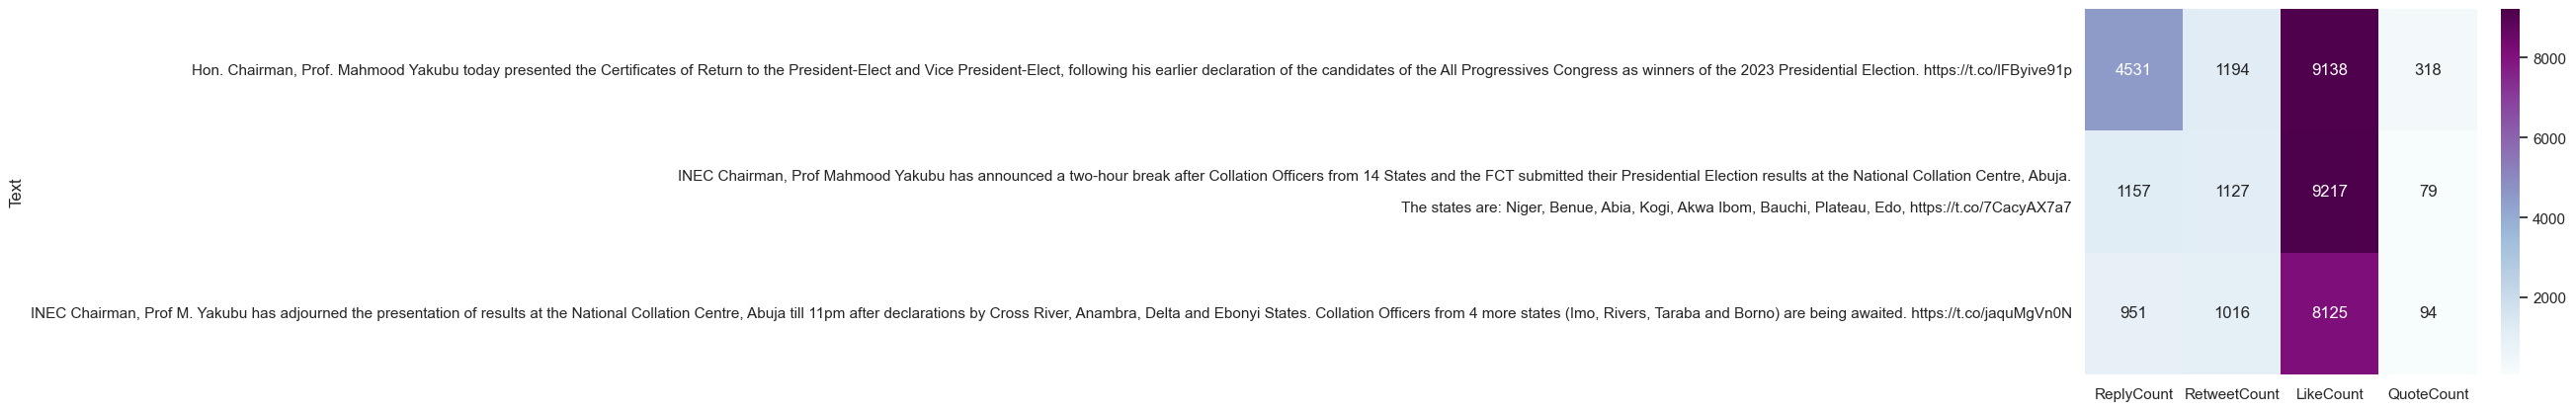

In [43]:
import pandas as pd
import seaborn as sns



# create a new column for total engagement count
tweets['EngagementCount'] = tweets['ReplyCount'] + tweets['RetweetCount'] + tweets['LikeCount'] + tweets['QuoteCount']

# select the top 10 tweets based on engagement count
top_3_tweets = tweets.nlargest(3, 'EngagementCount')

# select the columns of interest
columns = ['Text', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount']

# create a new DataFrame with only the selected columns and top 10 tweets
top_10_engagement = top_3_tweets[columns]

# use Seaborn to create a heatmap of the engagement metrics
heatmap = sns.heatmap(top_10_engagement.set_index('Text'), cmap='BuPu', annot=True, fmt='d')

# display the heatmap
heatmap


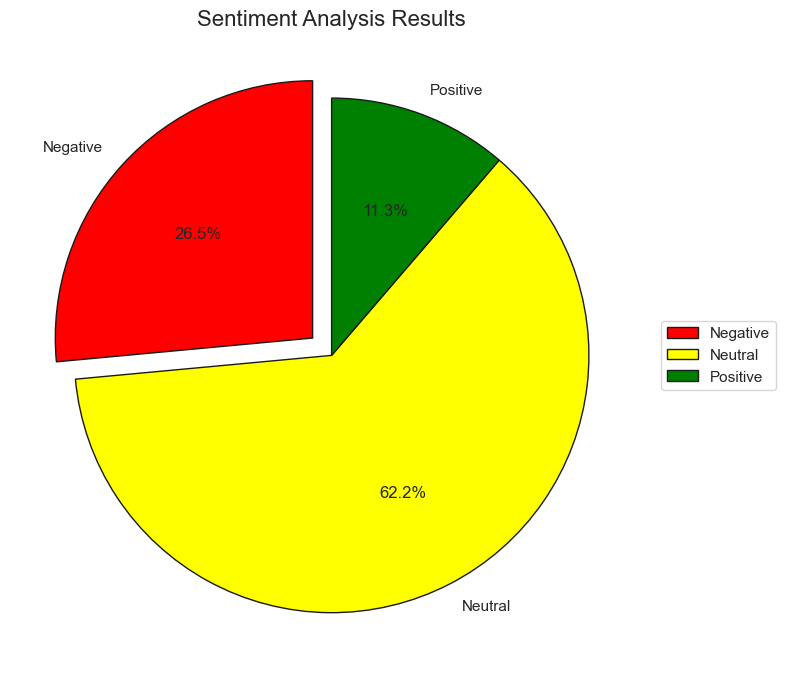

In [36]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Define custom colors for the chart
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# create a sentiment analyzer object
sia = SentimentIntensityAnalyzer()

# example text to analyze
text = tweets['Text'].iloc[0]

# get the sentiment scores for the text
scores = sia.polarity_scores(text)

# create a list of labels and a list of scores
labels = ['Negative', 'Neutral', 'Positive']
values = [scores['neg'], scores['neu'], scores['pos']]

# Define which slices to explode (i.e. pull out from the pie)
explode = [0.1, 0, 0]

# Create a pie chart of the sentiment analysis
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, colors=[colors[label] for label in labels], 
        explode=explode, autopct='%1.1f%%', startangle=90, 
        wedgeprops={"edgecolor":"k", 'linewidth': 1})

# Add a legend
plt.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))

# Add a title and adjust the layout
plt.title('Sentiment Analysis Results', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()




## Trends


In [76]:
trends = pd.read_csv("trends.csv")

trends.head(1)


,tweet_id,tweet_datetime,tweet_hashtags,tweet_language,retweet_count,tweet_source,tweet_source_url,tweet_text,user_created_datetime,user_name,user_followers_count,user_description,user_location,searched_by_hashtag,searched_at_datetime,searched_hashtag_country
0,1.43413E+18,04/09/2021 12:16,"AFLLionsDogs, AFLFinals",en,0,Twitter for Android,http://twitter.com/download/android,Footy 🥰🥰🥰🥰🥰 #AFLLionsDogs #AFLFinals,16/12/2016 6:50,Nathan,164.0,"Sport lover, Collingwood supporter, budding go...","Melbourne, Victoria",#AFLLionsDogs,15:49.9,Australia


In [78]:
# drop rows with missing values

trends.dropna(inplace=True)

# drop date column
#trends.drop('tweet_datetime', axis=1, inplace=True)



In [79]:
trends.columns

Index(['tweet_id', 'tweet_hashtags', 'tweet_language', 'retweet_count',
       'tweet_source', 'tweet_source_url', 'tweet_text',
       'user_created_datetime', 'user_name', 'user_followers_count',
       'user_description', 'user_location', 'searched_by_hashtag',
       'searched_at_datetime', 'searched_hashtag_country'],
      dtype='object')

In [80]:
trends.head(1)

,tweet_id,tweet_hashtags,tweet_language,retweet_count,tweet_source,tweet_source_url,tweet_text,user_created_datetime,user_name,user_followers_count,user_description,user_location,searched_by_hashtag,searched_at_datetime,searched_hashtag_country
0,1.43413E+18,"AFLLionsDogs, AFLFinals",en,0,Twitter for Android,http://twitter.com/download/android,Footy 🥰🥰🥰🥰🥰 #AFLLionsDogs #AFLFinals,16/12/2016 6:50,Nathan,164.0,"Sport lover, Collingwood supporter, budding go...","Melbourne, Victoria",#AFLLionsDogs,15:49.9,Australia


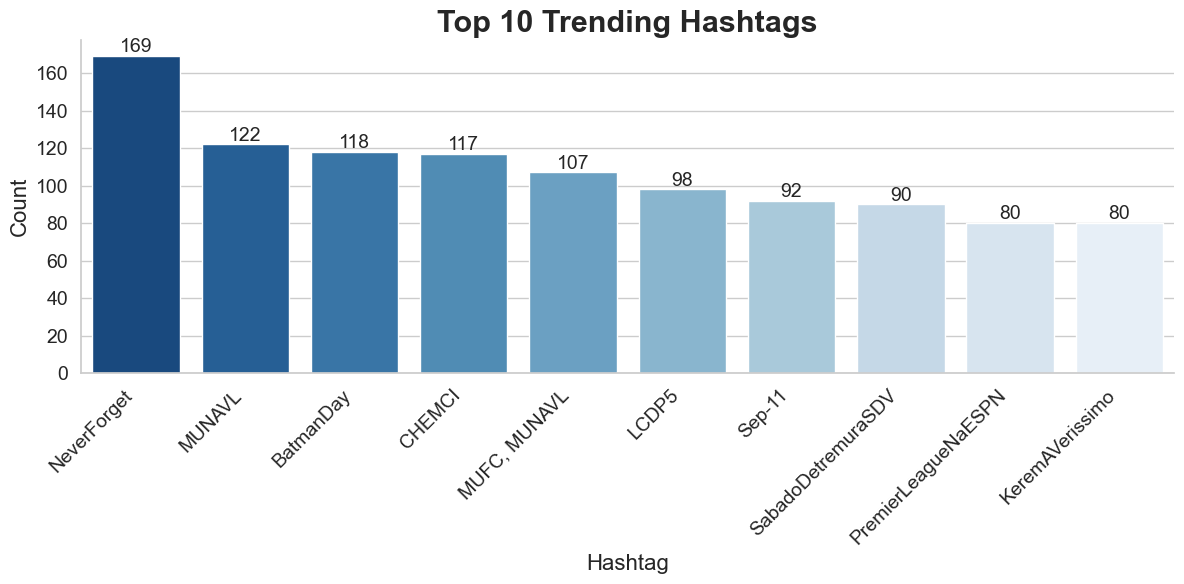

In [88]:
import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  trends is a pandas dataframe with tweet_text column
trends['tweet_text'] = trends['tweet_text'].astype(str)

# group tweets by hashtag and count the number of occurrences
hashtag_counts = trends.groupby('tweet_hashtags')['tweet_id'].count()

# sort hashtags by count in descending order and select the top 10
top_hashtags = hashtag_counts.sort_values(ascending=False)[:10]

# create a bar chart of the top hashtags
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values, palette='Blues_r')

# set the chart title and axis labels
ax.set_title('Top 10 Trending Hashtags', fontsize=22, fontweight='bold')
ax.set_xlabel('Hashtag', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

# set the tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
sns.despine(top=True, right=True)

# add value labels to the bars
for i, v in enumerate(top_hashtags.values):
    ax.text(i, v+2, str(v), ha='center', fontsize=14)

# adjust the plot layout
plt.tight_layout()

# display the chart
plt.show()



In [98]:
top_hashtags = trends['searched_by_hashtag'].value_counts().nlargest(10)
top_hashtags


#NeverForget           260
#MUNAVL                228
#BatmanDay             200
#SaturdayMorning       177
#September11           176
#CHEMCI                157
#WOLBRE                155
#FelizSabado           145
#LCDP5                 142
#SabadoDetremuraSDV    138
Name: searched_by_hashtag, dtype: int64

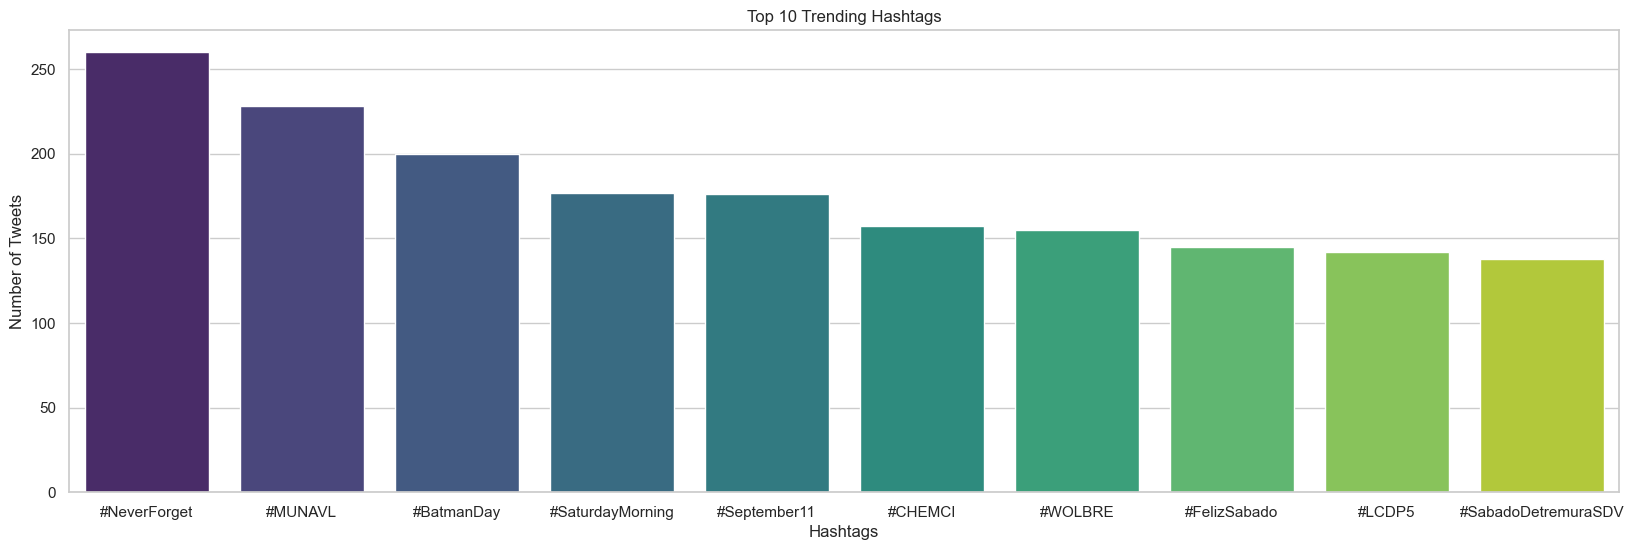

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# count the number of tweets for each searched by hashtag and get top 10
top_hashtags = trends['searched_by_hashtag'].value_counts().nlargest(10)

# create a bar plot
plt.figure(figsize=(20, 6))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values, palette='viridis')
plt.title('Top 10 Trending Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Number of Tweets')
plt.show()


## Sentiment Analysis


In [124]:

trends.columns

Index(['tweet_id', 'tweet_hashtags', 'tweet_language', 'retweet_count',
       'tweet_source', 'tweet_source_url', 'tweet_text',
       'user_created_datetime', 'user_name', 'user_followers_count',
       'user_description', 'user_location', 'searched_by_hashtag',
       'searched_at_datetime', 'searched_hashtag_country'],
      dtype='object')

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define custom colors for the chart
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# Create a SentimentIntensityAnalyzer object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Get positive tweets
positive_tweets = [tweet for tweet in tweets['Text'] if sia.polarity_scores(tweet)['compound'] > 0]

# Tokenize the positive tweets
positive_tokens = [word_tokenize(tweet) for tweet in positive_tweets]

# Filter out stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [[word for word in tweet if not word.lower() in stop_words] for tweet in positive_tokens]

# Calculate word frequencies
word_frequencies = FreqDist([word for tweet in filtered_tokens for word in tweet])

# Plot a frequency distribution of the top 20 words
plt.figure(figsize=(10, 5))
word_frequencies.plot(20)

# Generate a word cloud of the positive tweets
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join([word for tweet in filtered_tokens for word in tweet]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


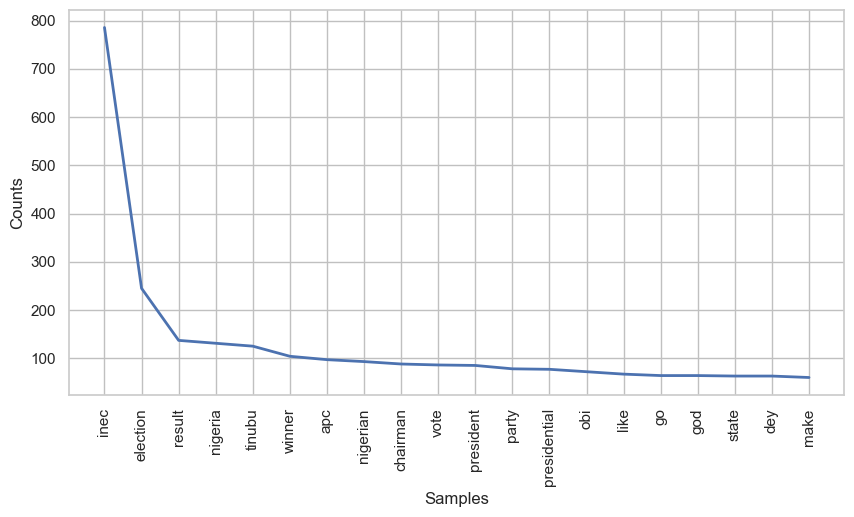

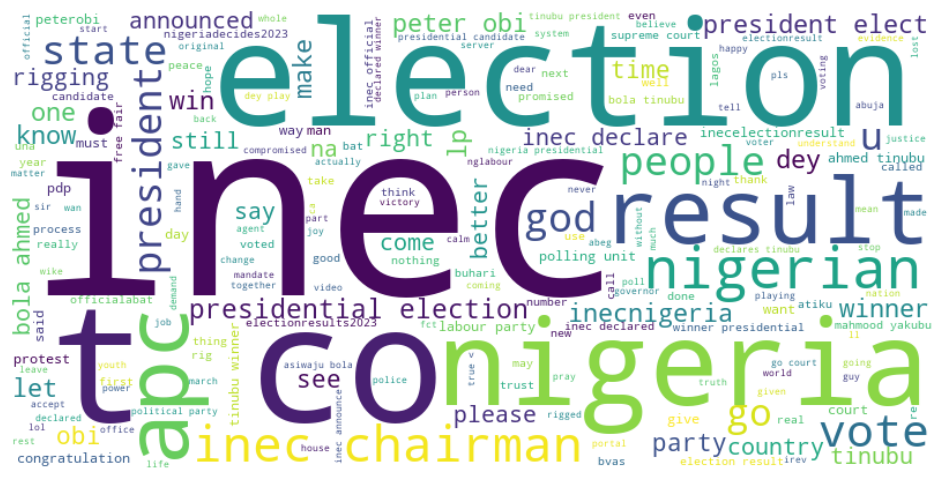

In [64]:
# Positive tweets word cloud and frequency distribution

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re
import matplotlib.pyplot as plt

# Define custom colors for the chart
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# Create a SentimentIntensityAnalyzer object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Get positive tweets
positive_tweets = [tweet for tweet in tweets['Text'] if sia.polarity_scores(tweet)['compound'] > 0]

# Tokenize the positive tweets
positive_tokens = [word_tokenize(tweet) for tweet in positive_tweets]

# Filter out stopwords, URLs, special characters, and short words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

filtered_tokens = [[lemmatizer.lemmatize(word.lower()) for word in tweet 
                    if word.lower() not in stop_words 
                    and not re.match(r'http\S+', word) 
                    and word.lower() not in string.punctuation 
                    and word.lower() not in ["'s", ",", ".", "n't", "u", "t.co", "https", "http", "amp", "rt"]
                    and len(word) > 1] 
                   for tweet in positive_tokens]

# Calculate word frequencies
word_frequencies = FreqDist([word for tweet in filtered_tokens for word in tweet])

# Plot a frequency distribution of the top 20 words
plt.figure(figsize=(10, 5))
word_frequencies.plot(20)

# Generate a word cloud of the positive tweets
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join([word for tweet in filtered_tokens for word in tweet]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


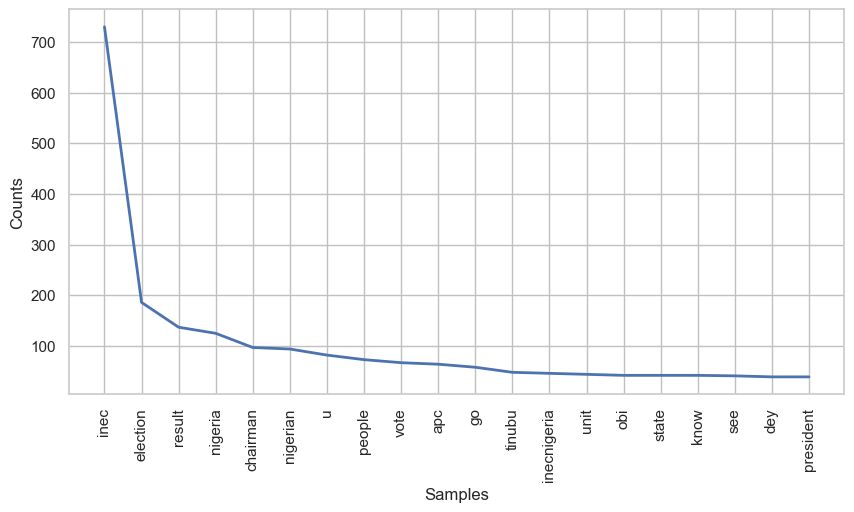

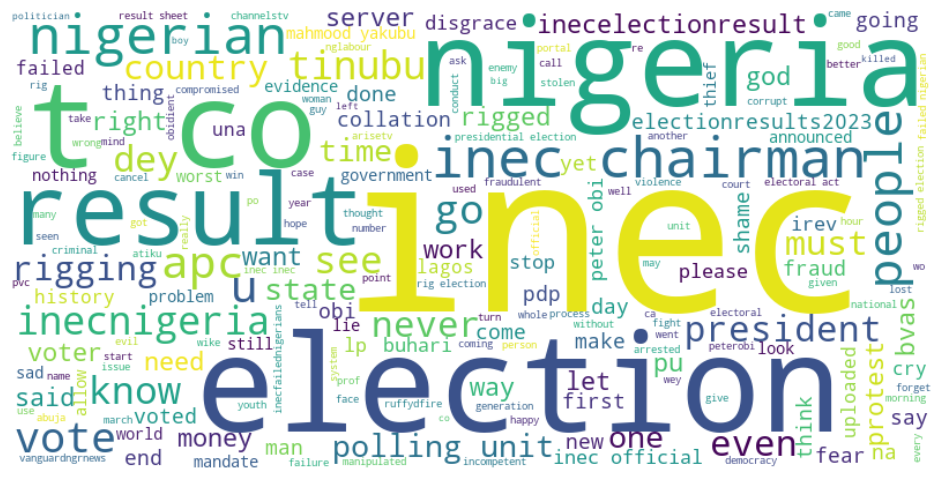

In [69]:
# Negative tweets word cloud and frequency distribution
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re
import matplotlib.pyplot as plt

# Define custom colors for the chart
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# Create a SentimentIntensityAnalyzer object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Get positive tweets
negative_tweets = [tweet for tweet in tweets['Text'] if sia.polarity_scores(tweet)['compound'] < 0]

# Tokenize the positive tweets
negative_tokens = [word_tokenize(tweet) for tweet in negative_tweets]

# Filter out stopwords, URLs, special characters, and short words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

filtered_tokens = [[lemmatizer.lemmatize(word.lower()) for word in tweet 
                    if word.lower() not in stop_words 
                    and not re.match(r'http\S+', word) 
                    and word.lower() not in string.punctuation 
                    and word.lower() not in ["'s", ",", ".", "n't", "u", "t.co", "https", "http", "amp", "rt"]
                    and len(word) > 1] 
                   for tweet in negative_tokens]

# Calculate word frequencies
word_frequencies2 = FreqDist([word for tweet in filtered_tokens for word in tweet])

# Plot a frequency distribution of the top 20 words
plt.figure(figsize=(10, 5))
word_frequencies2.plot(20)

# Generate a word cloud of the positive tweets
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join([word for tweet in filtered_tokens for word in tweet]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


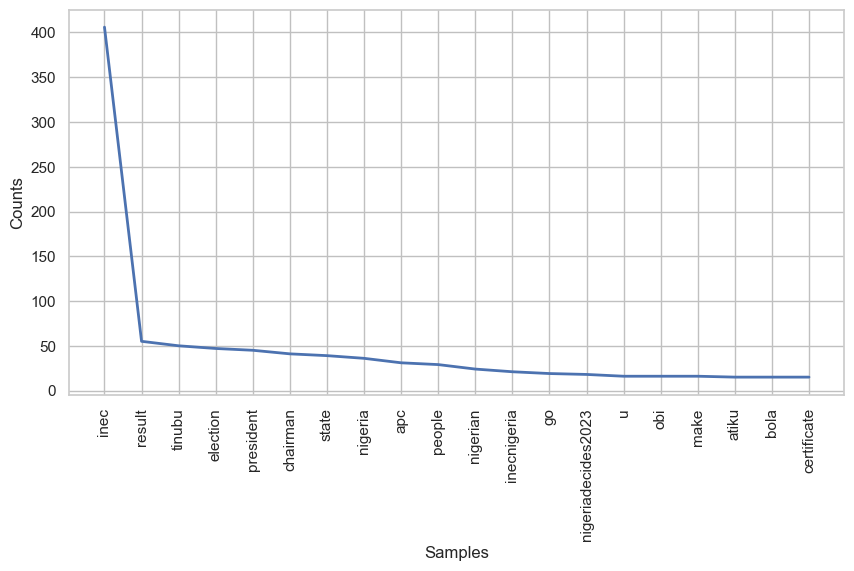

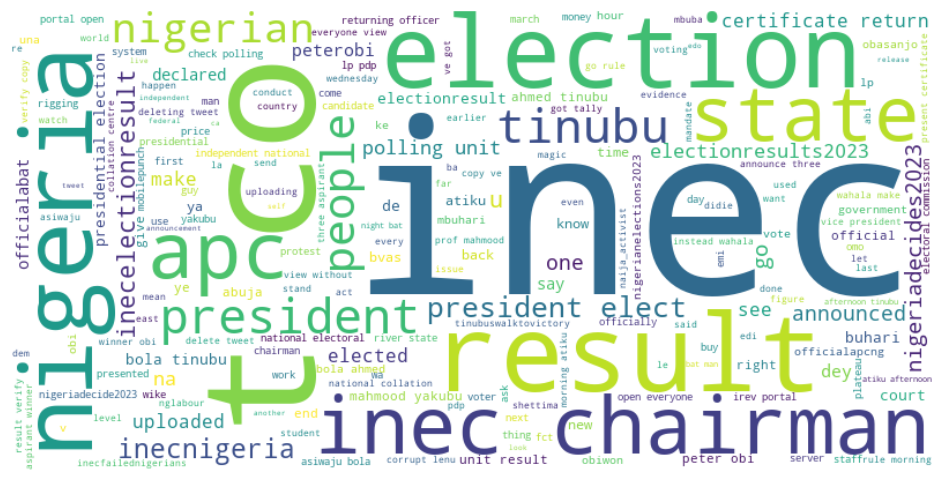

In [74]:
# Negative tweets word cloud and frequency distribution
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re
import matplotlib.pyplot as plt

# Define custom colors for the chart
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# Create a SentimentIntensityAnalyzer object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Get positive tweets
neutral_tweets = [tweet for tweet in tweets['Text'] if sia.polarity_scores(tweet)['compound'] == 0]

# Tokenize the positive tweets
neutral__tokens = [word_tokenize(tweet) for tweet in neutral_tweets]

# Filter out stopwords, URLs, special characters, and short words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

filtered_tokens = [[lemmatizer.lemmatize(word.lower()) for word in tweet 
                    if word.lower() not in stop_words 
                    and not re.match(r'http\S+', word) 
                    and word.lower() not in string.punctuation 
                    and word.lower() not in ["'s", ",", ".", "n't", "u", "t.co", "https", "http", "amp", "rt", "..", "..."]
                    and len(word) > 1] 
                   for tweet in neutral__tokens]

# Calculate word frequencies
word_frequencies2 = FreqDist([word for tweet in filtered_tokens for word in tweet])

# Plot a frequency distribution of the top 20 words
plt.figure(figsize=(10, 5))
word_frequencies2.plot(20)

# Generate a word cloud of the positive tweets
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join([word for tweet in filtered_tokens for word in tweet]))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()